Zofia Jankowska

<h2>AUTOENKODERY

In [9]:
import numpy as np
from keras.datasets import mnist
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

<h4>WCZYTANIE I KONWERSJA DANYCH

In [10]:
training_set, test_set = mnist.load_data()

X_train, y_train = training_set
X_test, y_test = test_set

X_train.shape

(60000, 28, 28)

In [11]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train.shape

(60000, 28, 28, 1)

In [12]:
X_train = X_train.astype(float) / 255.0  
X_test = X_test.astype(float) / 255.0

<h4>REDUKCJA WYMIAROWOŚCI Z WYKORZYSTANIEM PCA

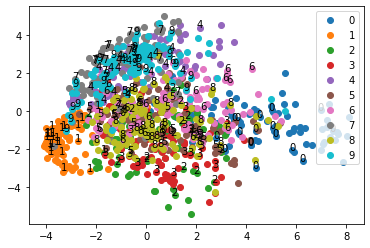

In [13]:
X_train_flatten = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
 
pca = PCA()
pca.fit(X_train_flatten)
 
X_test_flatten = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
Z_test_flatten = pca.transform(X_test_flatten)
Z_test_subset, _, y_test_subset, _ = train_test_split(Z_test_flatten, y_test, train_size=0.1, random_state=12345)
 
plt.figure()
for i in range(10):
    X_tmp = Z_test_subset[y_test_subset == i]
    plt.plot(X_tmp[:, 0], X_tmp[:, 1], 'o')
    for j in range(0, len(X_tmp), 5):
        plt.annotate(i, (X_tmp[j, 0], X_tmp[j, 1]), ha='center')
plt.legend(range(10))
plt.show()

<h4>REDUKCJA WYMIAROWOŚCI Z WYKORZYSTANIEM AUTOENKODERA

In [14]:
# Utworzenie modelu autoenkodera
input_shape = (28, 28, 1)
 
inputs = layers.Input(shape=input_shape)
 
flatten = layers.Flatten()(inputs)
dense1 = layers.Dense(50, activation='tanh')(flatten)
dense2 = layers.Dense(50, activation='tanh')(dense1)
latent = layers.Dense(2, activation='linear')(dense2)
dense3 = layers.Dense(50, activation='tanh')(latent)
dense4 = layers.Dense(50, activation='tanh')(dense3)
dense5 = layers.Dense(28 * 28, activation='relu')(dense4)
outputs = layers.Reshape(target_shape=(28, 28, 1))(dense5)
 
model = keras.Model(inputs=inputs, outputs=outputs)
 
model.compile(loss=keras.metrics.mse, optimizer="adam")

In [15]:

batch_size = 128
epochs = 50
model.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
375/375 [==============================] - 2s 3ms/step - loss: 0.0620 - val_loss: 0.0557
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0545 - val_loss: 0.0524
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0506 - val_loss: 0.0487
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0476 - val_loss: 0.0461
Epoch 5/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0456 - val_loss: 0.0447
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0444 - val_loss: 0.0435
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0434 - val_loss: 0.0429
Epoch 8/50
375/375 [==============================] - 1s 2ms/step - loss: 0.0427 - val_loss: 0.0422
Epoch 9/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0422 - val_loss: 0.0418
Epoch 10/50
375/375 [==============================] - 1s 3ms/step - loss: 0.0417 - val_loss: 0.0415

313/313 [==============================] - 0s 731us/step


<Figure size 432x288 with 0 Axes>

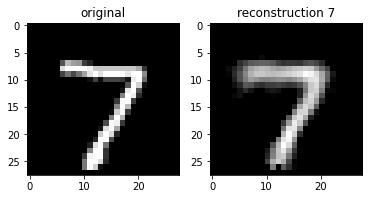

In [16]:

X_gen = model.predict(X_test)
 
example_id = 0
plt.figure()
fig, axs = plt.subplots(1, 2)
axs[0].imshow(X_test[example_id, :, :, 0], cmap='gray')
axs[0].set_title('original')
axs[1].imshow(X_gen[example_id, :, :, 0], cmap='gray')
axs[1].set_title(f'reconstruction {y_test[example_id]}')
plt.show()

32/32 [==============================] - 0s 686us/step


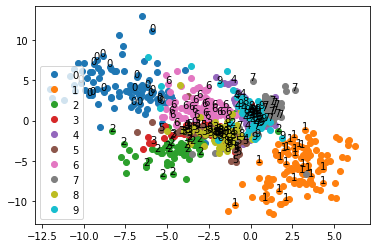

In [17]:

compression_model = keras.Model(inputs=inputs, outputs=latent)
 
X_test_subset, _, y_test_subset, _ = train_test_split(X_test, y_test, train_size=0.1, random_state=12345)
X_compressed = compression_model.predict(X_test_subset)
 
plt.figure()
for i in range(10):
    X_tmp = X_compressed[y_test_subset == i]
    plt.plot(X_tmp[:, 0], X_tmp[:, 1], 'o')
    for j in range(0, len(X_tmp), 5):
        plt.annotate(i, (X_tmp[j, 0], X_tmp[j, 1]), ha='center')
plt.legend(range(10))
plt.show()

Weryfikacja dekodera - podanie na wejście dwóch przykładowych wartości

1/1 [==============================] - 0s 48ms/step


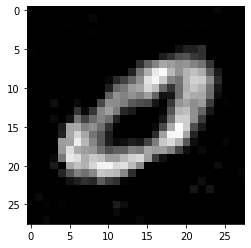

In [18]:

decoder = keras.Model(inputs=latent, outputs=outputs)
input_data = np.array([[-12.0, -2.0]])
random_img = decoder.predict(input_data)
plt.imshow(random_img[0, :, :, 0], cmap='gray')
plt.show()

1/1 [==============================] - 0s 15ms/step


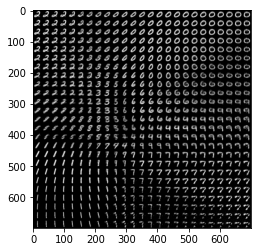

In [19]:
xs = np.linspace(-10, 6, 25)
ys = np.linspace(-7, 10, 25)
all_img = np.zeros([len(xs)*28, len(ys)*28], dtype=np.float32)
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        input_data = np.array([[x, y]])
        random_img = decoder.predict(input_data)
        all_img[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = random_img[0, :, :, 0]
all_img[all_img > 1.0] = 1.0
plt.imshow(all_img[:, :], cmap='gray')
plt.show()